# Overview

In [1]:
#File Name: Figure_4.ipynb
#Author: Matthias M. Fischer
#Last Revision: 17th March 2022
#Changelog: Initial Version.

#This file contains the complete commented source code
#for reproducing all plots from Figure 4 of the manuscript
#by Fischer and Blüthgen.

# Setup

In [1]:
# Library imports

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import optimize
import pandas as pd
import tqdm

In [2]:
# Convenience function:
# Return the maximum real part of all
# eigenvalues of a given matrix M

def lambdamax(M):
    return np.max(np.real(np.linalg.eigvals(M)))

In [3]:
# Return the coefficient matrix A describing
# the model where all NSCC compartments
# dedifferentiate

def A(K_C=1.0,                                        # CSC cycling rate
      K_N=1.0,                                        # NSCC cycling rate
      K_T=0.05,                                       # Dedifferentiation rate
      DeltaP = 0.18,                                  # Aggregate CSC fate choice parameter, Delta P := P_S - P_D
      D_C=0.05,                                       # CSC apoptosis rate
      D_N=0.05,                                       # NSCC apoptosis rate
      M=7):                                           # Number NSCC compartments
    
    beta = DeltaP*K_C - D_C                           # CSC compartment net growth rate
    iota = (1-DeltaP)*K_C                             # Influx rate compartment N_1, in multiples of C(t)
 
    A = np.zeros((M+1, M+1))                          # Initialise coefficient matrix A
    A[0,0] = beta                                     # A_{1,1} := beta
    A[1,0] = iota                                     # A_{2,1} := iota
    
    for i in range(1, M+1):                           # A_{1,i} := K_T for i in [2...M]
        A[0,i] = K_T
    
    for i in range(1, M):                             # A_{i,i} := -K_N - K_T - D_N for i in [1,M-1]
        A[i,i] = -K_N - K_T - D_N
    
    A[M,M] = -K_T - D_N                               # A_{M+1, M+1} := -K_T - D_N
    
    for i in range(2,M+1):                            # A_{i, i-1} := 2*K_N for i in [2, M]
        A[i,i-1] = 2*K_N
        
    return A

In [4]:
# Return a set of randomly drawn system parameters

def draw_parameter_set(K_C_range = (0.5, 1.5),                           # The sampling ranges of all parameter values
                 K_N_range = (0.5, 1.5),
                 K_T_range = (0, 0.1),
                 DeltaP_range = (0.01, 0.35),
                 D_C_range = (0, 0.1),
                 D_N_range = (0, 0.1),
                 M_range = (3, 11)):
        
    K_C = np.random.uniform(K_C_range[0], K_C_range[1])                  # Sampling
    K_N = np.random.uniform(K_N_range[0], K_N_range[1])
    K_T = np.random.uniform(K_T_range[0], K_T_range[1])
    DeltaP = np.random.uniform(DeltaP_range[0], DeltaP_range[1])           
    M = int (np.random.uniform(M_range[0], M_range[1]))        
    D_C = np.random.uniform(D_C_range[0], D_C_range[1])
    D_N = np.random.uniform(D_N_range[0], D_N_range[1])

    return K_C, K_N, K_T, DeltaP, D_C, D_N, M

# Figure 4B

In [5]:
# Helper function
# Calculate the NSCC apoptosis rate D_N_crit required to achieve
# negative tumour growth under standard parametrisation
# for a given dedifferentiation rate K_T
# and a given CSS apoptosis rate D_C

def D_N_critical(K_T, D_C):
    f = lambda D_N: lambdamax(A(K_T=K_T, D_N=D_N, D_C=D_C))

    if (f(0)<0) & (f(100)<0):
        return 0
    elif (f(0)>0) & (f(100)>0):
        return 1000
    else:
        return sp.optimize.bisect(f, 0, 100)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 296.26it/s]


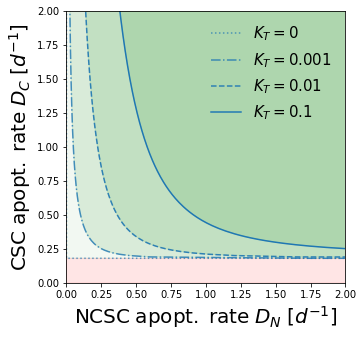

In [6]:
# For varying values of K_T
# calculate curves in (D_C, D_N) space,
# where treatments starts to work
K_Ts = [0, 0.001, 0.01, 0.1]


# All results will be stored here
# as a list of tuples of two lists each
results = []


# Computation
for K_T in K_Ts:
    # Results for current value of K_T go in here
    D_Ns = []
    D_Cs = []
    
    # For systematically altered CSC apoptosis rate D_C,
    for D_C in tqdm.tqdm(np.arange(0.001,2.1,0.01)):
        # save current D_C value,
        D_Cs.append(D_C)
        
        # and find corresponding D_N_critical,
        # where lambda_max becomes negative.
        D_Ns.append(D_N_critical(K_T=K_T, D_C=D_C))
    
    # Append a tuple with the two lists to the results
    results.append((D_Ns, D_Cs))


# Init plot
plt.subplots(1, 1, figsize=(5,5))

# First value of K_T
plt.plot(results[0][0], results[0][1], label=r"$K_T="+str(K_Ts[0])+"$",
         color="C0", alpha=0.7, linestyle=":")
plt.fill_between(results[0][0], 0, results[0][1], alpha=.1, color="red")
plt.fill_between(results[0][0], results[0][1], 100, alpha=.05, color="green")

# Second value of K_T
plt.plot(results[1][0], results[1][1], label=r"$K_T="+str(K_Ts[1])+"$",
         color="C0", alpha=0.8, linestyle="-.")
plt.fill_between(results[1][0], results[1][1], 100, alpha=.1, color="green")

# Third value of K_T
plt.plot(results[2][0], results[2][1], label=r"$K_T="+str(K_Ts[2])+"$",
         color="C0", alpha=0.9, linestyle="--")
plt.fill_between(results[2][0], results[2][1], 100, alpha=.1, color="green")

# Fourth value of K_T
plt.plot(results[3][0], results[3][1], label=r"$K_T="+str(K_Ts[3])+"$",
         color="C0", alpha=1.0, linestyle="-")
plt.fill_between(results[3][0], results[3][1], 100, alpha=.1, color="green")


# Limits, labels, legend, aesthetics
plt.xlim((0,2))
plt.ylim((0,2))
plt.xlabel("$\mathrm{NCSC \; apopt. \; rate \; }D_N \; [d^{-1}]$", fontsize=20)
plt.ylabel("$\mathrm{CSC \; apopt. \; rate \; }D_C \; [d^{-1}]$", fontsize=20)
leg = plt.legend(loc=1, fontsize=15, frameon=False)
alphas = [.7,.8,.9,.99]
for lh, a in zip(leg.legendHandles, alphas): 
    lh.set_alpha(a)

# Figure 4C

In [7]:
# Function of the simulation of a virtual cohort:
# Compare application of apoptosis-inducing treatment
# between CSC-only, NSCC-only, and double-targeting
# Dedifferentiation rate K_T is varied systematically,
# instead of drawn randomly
def cohort_trial_apoptosis(n = 1000,                                    # Nb. of virtual patients to simulate
                    random_seed = 0,                                    # Random seed for reproducibility
                    apoptosis_rate_range = (0,1),                       # Effect size range to sample from
                    K_T = None):                                        # Dedifferentiation rate K_T

    results = []                                                        # Results to be stored here
    np.random.seed(random_seed)                                         # Set random seed
    
    with tqdm.tqdm(total = n) as pbar:                                  # Progress bar
        while len(results) < n:                                         # As long as we need more patients:
            params = draw_parameter_set()                               # Draw new parameter vector
            K_C, K_N, _, DeltaP, D_C, D_N, M = params                   # Split it into individual variables
            
            lambda_baseline = lambdamax(A(*params))                     # Check if patient is eligible
            beta = DeltaP*K_C - D_C
            if 0.01 < lambda_baseline < 0.2 and beta > 0:                
                f = lambda D_C, D_N: lambdamax(A(D_C=D_C,               # Def. convenience function for easier call
                                                 D_N=D_N,
                                                 K_C=K_C,
                                                 K_N=K_N,
                                                 DeltaP=DeltaP,
                                                 K_T=K_T,
                                                 M=M))
                
                apop = np.random.uniform(*apoptosis_rate_range)         # Sample random treatment effect size
                
                lambda_CSC = f(D_C=D_C+apop, D_N=D_N)                   # Eigenvalue if only CSCs are targeted
                lambda_NSCC = f(D_C=D_C, D_N=D_N+apop)                  # Eigenvalue if only NSCCs are targeted
                lambda_both = f(D_C=D_C+apop, D_N=D_N+apop)             # Eigenvalue double-targeting
                    
                results.append((lambda_baseline,                        # Save result for current patient
                                lambda_CSC,
                                lambda_NSCC,
                                lambda_both))        
                pbar.update(1)
            
    results = pd.DataFrame(results, columns=["Baseline", "CSC", "NSCC", "Both"])
    return results

In [8]:
# For systematically varied values of K_T,
K_Ts = np.arange(0, 0.105, 0.0025)

# we record the number of successes per
# treatment approach here
nb_successes_CSC = []
nb_successes_NSCC = []
nb_successes_both = []

# Run the virtual trials
for K_T in K_Ts:
    # List of eigenvalues 
    results = cohort_trial_apoptosis(K_T=K_T)

    # Count successful treatments per treatment approach
    nb_successes = (results.iloc[:, [1,2,3]] < 0).sum(axis=0)
    
    # Append counts
    nb_successes_CSC.append(nb_successes[0])
    nb_successes_NSCC.append(nb_successes[1])
    nb_successes_both.append(nb_successes[2])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 237.26it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 235.43it/s]


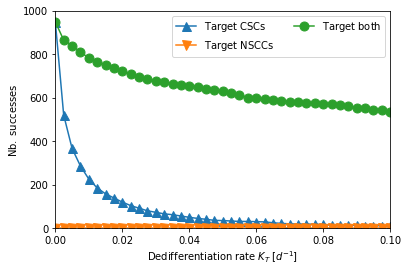

In [9]:
# Plot
plt.plot(K_Ts, nb_successes_CSC, label=r"$\mathrm{Target \; CSCs}$", marker="^", markersize=9)
plt.plot(K_Ts, nb_successes_NSCC, label=r"$\mathrm{Target \; NSCCs}$", marker="v", markersize=9)
plt.plot(K_Ts, nb_successes_both, label=r"$\mathrm{Target \; both}$", marker="o", markersize=9)

plt.xlim((0,.1))
plt.ylim((0,1000))
plt.xlabel(r"$\mathrm{Dedifferentiation \; rate \; } K_{T} \; [d^{-1}]$")
plt.ylabel(r"$\mathrm{Nb. \; successes }$")
plt.legend(ncol=2)


# Figure 4E

In [10]:
# Helper function
# Calculate the NSCC cycling rate K_N_crit required to achieve
# negative tumour growth under standard parametrisation
# for a given dedifferentiation rate K_T
# and a given CSS cycling rate K_C

def K_N_critical(K_T, K_C):
    f = lambda K_N: lambdamax(A(K_T=K_T, K_N=K_N, K_C=K_C))

    if (f(0)<0) & (f(2)<0):
        return 1000
    elif (f(0)>0) & (f(100)>0):
        return 0
    else:
        return sp.optimize.bisect(f, 0, 100)

In [11]:
# For varying values of K_T
# calculate curves in (K_C, K_N) space,
# where treatments starts to work
K_Ts = [0, 0.001, 0.01, 0.1]


# All results will be stored here
# as a list of tuples of two lists each
results = []


# Computation
for K_T in K_Ts:
    # Results for current value of K_T go in here
    K_Ns = []
    K_Cs = []
    
    # For systematically altered CSC cycling rate K_C,
    for K_C in tqdm.tqdm(np.arange(0.001,2.1,0.01)):
        # save current K_C value,
        K_Cs.append(K_C)
        
        # and find corresponding K_N_critical,
        # where lambda_max becomes negative.
        K_Ns.append(K_N_critical(K_T=K_T, K_C=K_C))
    
    # Append a tuple with the two lists to the results
    results.append((K_Ns, K_Cs))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 2645.47it/s]


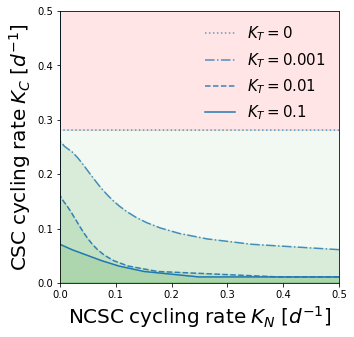

In [12]:
# Init plot
plt.subplots(1, 1, figsize=(5,5))

# First value of K_T
plt.plot(results[0][0], results[0][1], label=r"$K_T="+str(K_Ts[0])+"$",
         color="C0", alpha=0.7, linestyle=":")
plt.fill_between(results[0][0], results[0][1], 100, alpha=.1, color="red")
plt.fill_between(results[0][0], 0, results[0][1], alpha=.05, color="green")

# Second value of K_T
plt.plot(results[1][0], results[1][1], label=r"$K_T="+str(K_Ts[1])+"$",
         color="C0", alpha=0.8, linestyle="-.")
plt.fill_between(results[1][0], 0, results[1][1], alpha=.1, color="green")

# Third value of K_T
plt.plot(results[2][0], results[2][1], label=r"$K_T="+str(K_Ts[2])+"$",
         color="C0", alpha=0.9, linestyle="--")
plt.fill_between(results[2][0], 0, results[2][1], alpha=.1, color="green")

# Fourth value of K_T
plt.plot(results[3][0], results[3][1], label=r"$K_T="+str(K_Ts[3])+"$",
         color="C0", alpha=1.0, linestyle="-")
plt.fill_between(results[3][0], 0, results[3][1], alpha=.1, color="green")


# Limits, labels, legend, aesthetics
plt.xlim((0,0.5))
plt.ylim((0,0.5))
plt.xlabel("$\mathrm{NCSC \; cycling \; rate \; }K_N \; [d^{-1}]$", fontsize=20)
plt.ylabel("$\mathrm{CSC \; cycling \; rate \; }K_C \; [d^{-1}]$", fontsize=20)
leg = plt.legend(loc=1, fontsize=15, frameon=False)
alphas = [.7,.8,.9,.99]
for lh, a in zip(leg.legendHandles, alphas): 
    lh.set_alpha(a)

# Figure 4F

In [13]:
# Function of the simulation of a virtual cohort:
# Compare application of cell cycle inhibitor
# between CSC-only, NSCC-only, and double-targeting
# Dedifferentiation rate K_T is varied systematically,
# instead of drawn randomly
def cohort_trial_ccinhib(n = 1000,                                      # Nb. of virtual patients to simulate
                    random_seed = 0,                                    # Random seed for reproducibility
                    cc_inhib_range = (0,1),                             # Effect size range to sample from
                    K_T = None):                                        # Dedifferentiation rate K_T

    results = []                                                        # Results to be stored here
    np.random.seed(random_seed)                                         # Set random seed
    
    with tqdm.tqdm(total = n) as pbar:                                  # Progress bar
        while len(results) < n:                                         # As long as we need more patients:
            params = draw_parameter_set()                               # Draw new parameter vector
            K_C, K_N, _, DeltaP, D_C, D_N, M = params                   # Split it into individual variables
            
            lambda_baseline = lambdamax(A(*params))                     # Check if patient is eligible
            beta = DeltaP*K_C - D_C
            if 0.01 < lambda_baseline < 0.2 and beta > 0:                
                f = lambda K_C, K_N: lambdamax(A(D_C=D_C,               # Def. convenience function for easier call
                                                 D_N=D_N,
                                                 K_C=K_C,
                                                 K_N=K_N,
                                                 DeltaP=DeltaP,
                                                 K_T=K_T,
                                                 M=M))
                
                ccinhib = np.random.uniform(*cc_inhib_range)            # Sample random treatment effect size
                
                lambda_CSC = f(K_C=K_C*ccinhib, K_N=K_N)                # Eigenvalue if only CSCs are targeted
                lambda_NSCC = f(K_C=K_C, K_N=K_N*ccinhib)               # Eigenvalue if only NSCCs are targeted
                lambda_both = f(K_C=K_C*ccinhib, K_N=K_N*ccinhib)       # Eigenvalue double-targeting
                    
                results.append((lambda_baseline,                        # Save result for current patient
                                lambda_CSC,
                                lambda_NSCC,
                                lambda_both))        
                pbar.update(1)
            
    results = pd.DataFrame(results, columns=["Baseline", "CSC", "NSCC", "Both"])
    return results

In [14]:
# For systematically varied values of K_T,
K_Ts = np.arange(0, 0.105, 0.0025)

# we record the number of successes per
# treatment approach here
nb_successes_CSC = []
nb_successes_NSCC = []
nb_successes_both = []

# Run the virtual trials
for K_T in K_Ts:
    # List of eigenvalues 
    results = cohort_trial_ccinhib(K_T=K_T)

    # Count successful treatments per treatment approach
    nb_successes = (results.iloc[:, [1,2,3]] < 0).sum(axis=0)
    
    # Append counts
    nb_successes_CSC.append(nb_successes[0])
    nb_successes_NSCC.append(nb_successes[1])
    nb_successes_both.append(nb_successes[2])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 238.84it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 239.77it/s]


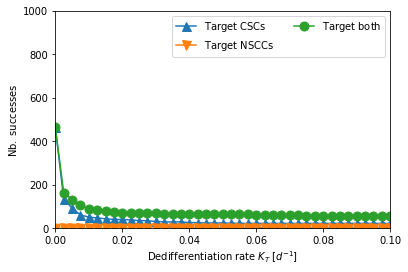

In [17]:
# Plot
plt.plot(K_Ts, nb_successes_CSC, label=r"$\mathrm{Target \; CSCs}$", marker="^", markersize=9)
plt.plot(K_Ts, nb_successes_NSCC, label=r"$\mathrm{Target \; NSCCs}$", marker="v", markersize=9)
plt.plot(K_Ts, nb_successes_both, label=r"$\mathrm{Target \; both}$", marker="o", markersize=9)

plt.xlim((0,.1))
plt.ylim((0,1000))
plt.xlabel(r"$\mathrm{Dedifferentiation \; rate \; } K_{T} \; [d^{-1}]$")
plt.ylabel(r"$\mathrm{Nb. \; successes }$")
plt.legend(ncol=2)
